In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from math import*

In [143]:
import copy
from graphviz import Digraph

In [144]:
from pandas.io.parsers.readers import read_csv

datasets={'tennis':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/data.csv','PlayTennis'],'cars':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/car.csv','class'],'lenses':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/lenses.csv','Class'],'chess':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/kr-vs-kp.csv','result']}

dataset='cars'

dataset_url,target_name=datasets[dataset]

data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [145]:
print(data)

     buying  maint  doors persons lug_boot safety  class
0     vhigh  vhigh      2       2    small    low  unacc
1     vhigh  vhigh      2       2    small    med  unacc
2     vhigh  vhigh      2       2    small   high  unacc
3     vhigh  vhigh      2       2      med    low  unacc
4     vhigh  vhigh      2       2      med    med  unacc
...     ...    ...    ...     ...      ...    ...    ...
1723    low    low  5more    more      med    med   good
1724    low    low  5more    more      med   high  vgood
1725    low    low  5more    more      big    low  unacc
1726    low    low  5more    more      big    med   good
1727    low    low  5more    more      big   high  vgood

[1728 rows x 7 columns]


In [146]:
data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [147]:
print(pd.DataFrame(data))
df=pd.DataFrame(data)
df.dtypes

     buying  maint  doors persons lug_boot safety  class
0     vhigh  vhigh      2       2    small    low  unacc
1     vhigh  vhigh      2       2    small    med  unacc
2     vhigh  vhigh      2       2    small   high  unacc
3     vhigh  vhigh      2       2      med    low  unacc
4     vhigh  vhigh      2       2      med    med  unacc
...     ...    ...    ...     ...      ...    ...    ...
1723    low    low  5more    more      med    med   good
1724    low    low  5more    more      med   high  vgood
1725    low    low  5more    more      big    low  unacc
1726    low    low  5more    more      big    med   good
1727    low    low  5more    more      big   high  vgood

[1728 rows x 7 columns]


buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

In [148]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

buying      1728
maint       1728
doors       1728
persons     1728
lug_boot    1728
safety      1728
class       1728
dtype: int64
1728


In [149]:
import random
def train_test_split(df,test_size):
  df=df.sample(frac = 1)
  n=len(df)
  no_test_rows=int(n*test_size)
  l=list(random.sample(list(range(n)), no_test_rows))
  test=df.iloc[l]
  train=df.drop(l,axis=0)
  return train.sample(frac = 1),test.sample(frac = 1)
# test_df=data
df,test_df=train_test_split(df,0.3)
print(len(df),len(test_df))

# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

1210 518


In [150]:
class DecisionTree():
  
  ## Class Member Functions ##

  def entropy_help(p):
    return -p*log(p,2)
  
  def getEntropy(df,target_name):  
    n=df.count()[0]
    target_counts=df[target_name].value_counts().to_dict()
    s=0
    for p in target_counts.values():
      if p/n==1 or p/n==0:
        return 0
      s+=DecisionTree.entropy_help(p/n)
    return s
  
  def getProbability(df,column,value):
    return df[df[column]==value].count()[0]/df.count()[0]
  
  def informationGain(df,target_name,col):
    total_entropy=DecisionTree.getEntropy(df,target_name)
    col_vals_count=df[col].value_counts().to_dict()
    sum=0
    for value in col_vals_count:
      n=col_vals_count[value]
      sum+=(DecisionTree.getEntropy(df[df[col]==value],target_name)*DecisionTree.getProbability(df,col,value))
    return total_entropy-sum

  ## Class Data Members ##

  split_functions={'IG':informationGain}
  
  ## Countructor ##
  def __init__(self,df,target_name,split_function="IG"):
    self.tree=self.Tree()
    self.df=df
    self.target_name=target_name
    self.cols=list(self.df.columns)
    self.cols.remove(self.target_name)
    self.cnt=0
    self.gnodes=[]
    self.output_classes=self.df[self.target_name].unique()
    if split_function in DecisionTree.split_functions:
      self.split_function=DecisionTree.split_functions[split_function]
    else:
      raise Exception("Split function not found")

  ## Instance Methods ##

  def getGraph(self):
    return self.tree.g

  def find_leaf(self,df):
      unique_vals=list(df[self.target_name].unique())
      for val in unique_vals:      
        if df[df[self.target_name]==val].count()[0]==df.count()[0]:
          return val

  def construct(self):
    maxig=[-1,""]
    for i in self.cols:
      etemp=self.split_function(df,self.target_name,i)
      maxig=maxig if maxig[0]>etemp else [etemp,i]
    root=self.Node(maxig[1],maxig[0],0)
    self.tree.insert_root(root)
    c=copy.deepcopy(self.cols)
    c.remove(root.name)
    self.gnodes.append(root)
    root.gname=str(root)
    self.tree.g.node(str(root),str(root))
    self.construct_help(df,c,root)

  def construct_help(self,df,cols,parent):
    vals=list(df[parent.name].unique())
    dftemp=df

    for k in vals:
      df=dftemp
      df=df[df[parent.name]==k]
      e=DecisionTree.getEntropy(df,self.target_name)

      if e==0:
        value=self.find_leaf(df)
        node=self.Node(value,1,parent.level+1)
        parent.insert_child(node)
        parent.insert_edge(k)
        self.tree.no_leafs+=1
        name=value
        if not isinstance(value, str):
          name='class'
        self.tree.g.node(name+str(self.cnt),str(value))
        self.tree.g.edge(str(parent.gname),name+str(self.cnt),label=str(k))
        
        self.cnt+=1
        continue
      maxig=[-1,""]
      for i in cols:
        etemp=self.split_function(df,self.target_name,i)
        maxig=maxig if maxig[0]>etemp else [etemp,i]
      node=self.Node(maxig[1],maxig[0],parent.level+1)
     
      c=copy.deepcopy(cols)
      
      c.remove(node.name)
      name=str(node)
      if name in self.gnodes:
        name+=str(self.cnt)
        self.cnt+=1
      else:
        self.gnodes.append(name)
      node.gname=name
      self.tree.g.node(name,str(node))
      parent.insert_child(node)
      parent.insert_edge(k)
      self.tree.g.edge(str(parent.gname),name,label=str(k))
      self.construct_help(df[df[parent.name]==k],c,node)
      
  def predict(self,instances,trace=False):
    node=self.tree.root
    op=[]
    if isinstance(instances,dict):
      return self.predict_help(node,instances,trace,"")
    if isinstance(instances,list):
      
      for instance in instances:
        op.append(self.predict_help(node,instance,trace,""))
    else:
      n=len(instances)
      for i in range(n):
        instance=data.iloc[i].to_dict()
        op.append(self.predict_help(node,instance,trace,""))
    return op

  def predict_help(self,node,instance,trace,path):
    if node.name in self.output_classes:
      if trace:
        print(path+str(node))
      return node.name
    value=instance[node.name]
    try:
      path+=str(node)+" ( "+str(value)+" ) ->"
      ind=node.edges.index(value)
      return self.predict_help(node.childs[ind],instance,trace,path)
    except Exception as e:
      return "Not valid instance, path: "+path
  
  ## Inner classes ##
  class Node:
    ## Countructor ##
    def __init__(self,name,ig,level):
      self.name=name
      self.ig=ig
      self.childs=[]
      self.edges=[]
      self.gname=''
      self.level=level

    ## Instance Methods ##

    def insert_child(self,node):
      self.childs.append(node)

    def insert_edge(self,edge):
      self.edges.append(edge)

    def printn(self):
      if self.childs:
        print(''.join(['-']*31))
        print('|{:^15} - level - {:^2} | '.format(self.name,self.level),list(zip(self.edges,list(map(str,self.childs)))))
        print(''.join(['-']*31))
      
    def __str__(self):
      return str(self.name)

  class Tree:

    ## Countructor ##
    def __init__(self):
      self.root=None
      self.g=Digraph(encoding='utf-8')
      self.no_leafs=0

    ## Instance Methods ##

    def insert_root(self,node):
      self.root=node

    def printt(self):
      self.print_help(self.root)

    def print_help(self,node):
      if node:
        node.printn()
      for i in node.childs:
        self.print_help(i)

In [151]:
d=DecisionTree(data,target_name,split_function="IG")

In [152]:
d.construct()

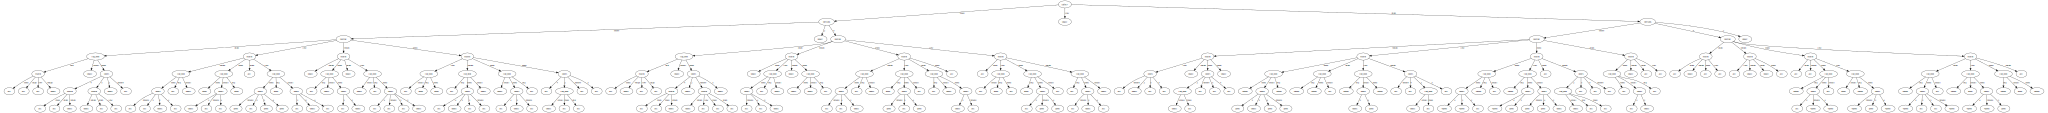

In [153]:
d.getGraph()

In [154]:
print(d.tree.no_leafs)

210


In [155]:
inp=[]
n=1000
n=n if n < len(test_df) else len(test_df)
for i in range(n):
  inp.append(test_df.iloc[i].to_dict())
print(d.predict(inp))

['unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'Not valid instance, path: safety ( med ) ->persons ( 4 ) ->buying ( med ) ->maint ( high ) ->lug_boot ( med ) ->doors ( 4 ) ->', 'good', 'acc', 'acc', 'acc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'acc', 'unacc', 'unacc', 'good', 'unacc', 'acc', 'unacc', 'acc', 'unacc', 'acc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'acc', 'unacc', 'una

In [156]:
d.tree.printt()

-------------------------------
|    safety      - level - 0  |  [('med', 'persons'), ('low', 'unacc'), ('high', 'persons')]
-------------------------------
-------------------------------
|    persons     - level - 1  |  [('more', 'buying'), ('2', 'unacc'), ('4', 'buying')]
-------------------------------
-------------------------------
|    buying      - level - 2  |  [('high', 'lug_boot'), ('low', 'maint'), ('vhigh', 'maint'), ('med', 'maint')]
-------------------------------
-------------------------------
|   lug_boot     - level - 3  |  [('big', 'maint'), ('small', 'unacc'), ('med', 'doors')]
-------------------------------
-------------------------------
|     maint      - level - 4  |  [('med', 'acc'), ('high', 'acc'), ('low', 'acc'), ('vhigh', 'unacc')]
-------------------------------
-------------------------------
|     doors      - level - 4  |  [('4', 'maint'), ('3', 'maint'), ('2', 'unacc'), ('5more', 'acc')]
-------------------------------
-------------------------------

In [157]:
o=list(enumerate(d.predict(data)))
o

[(0, 'unacc'),
 (1, 'unacc'),
 (2, 'unacc'),
 (3, 'unacc'),
 (4, 'unacc'),
 (5, 'unacc'),
 (6, 'unacc'),
 (7, 'unacc'),
 (8, 'unacc'),
 (9, 'unacc'),
 (10, 'unacc'),
 (11, 'unacc'),
 (12, 'unacc'),
 (13, 'unacc'),
 (14, 'unacc'),
 (15, 'unacc'),
 (16, 'unacc'),
 (17, 'unacc'),
 (18, 'unacc'),
 (19, 'unacc'),
 (20, 'unacc'),
 (21, 'unacc'),
 (22, 'unacc'),
 (23, 'unacc'),
 (24, 'unacc'),
 (25, 'unacc'),
 (26, 'unacc'),
 (27, 'unacc'),
 (28, 'unacc'),
 (29, 'unacc'),
 (30, 'unacc'),
 (31, 'unacc'),
 (32, 'unacc'),
 (33, 'unacc'),
 (34, 'unacc'),
 (35, 'unacc'),
 (36, 'unacc'),
 (37, 'unacc'),
 (38, 'unacc'),
 (39, 'unacc'),
 (40, 'unacc'),
 (41, 'unacc'),
 (42, 'unacc'),
 (43, 'unacc'),
 (44, 'unacc'),
 (45, 'unacc'),
 (46, 'unacc'),
 (47, 'unacc'),
 (48, 'unacc'),
 (49, 'unacc'),
 (50, 'unacc'),
 (51, 'unacc'),
 (52, 'unacc'),
 (53, 'unacc'),
 (54, 'unacc'),
 (55, 'unacc'),
 (56, 'unacc'),
 (57, 'unacc'),
 (58, 'unacc'),
 (59, 'unacc'),
 (60, 'unacc'),
 (61, 'unacc'),
 (62, 'unacc'),
 (

In [158]:
data[target_name]

0       unacc
1       unacc
2       unacc
3       unacc
4       unacc
        ...  
1723     good
1724    vgood
1725    unacc
1726     good
1727    vgood
Name: class, Length: 1728, dtype: object

In [159]:
count=0
for i in o:
  if i[1]=='Not valid instance':
    print("Something went wrong")
    count+=1
print(count)

0


In [160]:
print(df.iloc[0].to_dict())
d.predict(df.iloc[0].to_dict(),trace=True)

{'buying': 'high', 'maint': 'med', 'doors': '4', 'persons': 'more', 'lug_boot': 'big', 'safety': 'med', 'class': 'acc'}
safety ( med ) ->persons ( more ) ->buying ( high ) ->lug_boot ( big ) ->maint ( med ) ->acc


'acc'